# 1. Library

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as snsa
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Average
from keras.layers import BatchNormalization
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model
from keras.models import Model

# 2. Data

서울 데이터

In [239]:
train_df = pd.read_csv("/content/drive/MyDrive/제목없는 폴더/OBS_ASOS_DD_20201207220648.csv", encoding="utf-8",parse_dates=['date'], index_col=0).dropna(axis=0)
test_df = pd.read_csv("/content/drive/MyDrive/제목없는 폴더/OBS_ASOS_DD_20201207220648_TEST.csv", encoding="utf-8",parse_dates=['date'], index_col=0).dropna(axis=0)

인도 데이터

In [228]:
train_df = pd.read_csv("/content/drive/MyDrive/제목없는 폴더/data/Train.csv", encoding="utf-8",parse_dates=['date'], index_col=0)
test_df = pd.read_csv("/content/drive/MyDrive/제목없는 폴더/data/Test.csv", encoding="utf-8",parse_dates=['date'], index_col=0)

In [240]:
St_sc=StandardScaler()
train_st=St_sc.fit_transform(train_df)

mm_sc=MinMaxScaler()
train_mm=mm_sc.fit_transform(train_st)

In [241]:
#다변량 sequence 분리
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # n_step씩 분리
        end_ix = i + n_steps
        # dataset 끝까지
        if end_ix > len(sequences)-1:
            break
        # input, ouput
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [242]:
train=train_mm[:-1,:]
n_steps=3
Sx,Sy=split_sequences(train,n_steps)
n_features=Sx.shape[2]

In [243]:
Mx=train_mm[0:-2]
My=train_mm[1:-1]

In [244]:
# first input model
visible1 = Input(shape=(n_steps, n_features))
cnn = Conv1D(filters=64, kernel_size=2, padding='causal',activation='relu')(visible1)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Dropout(0.2)(cnn)
cnn = Flatten()(cnn)
cnn = Dense(n_features)(cnn)

In [245]:
visible2 = Input(shape=(n_steps, n_features))
mlp = Flatten()(visible2)
mlp = Dense(37, activation='relu')(mlp)
mlp = Dense(37, activation='relu')(mlp)
mlp = Dense(37, activation='relu')(mlp)
mlp = Dense(37, activation='relu')(mlp)
mlp = Dense(37, activation='relu')(mlp)
mlp = Dense(n_features)(mlp)

In [246]:
merge = concatenate([cnn, mlp])


In [247]:
output = Dense(n_features)(merge)

In [248]:
model = Model(inputs=[visible1, visible2], outputs=output)

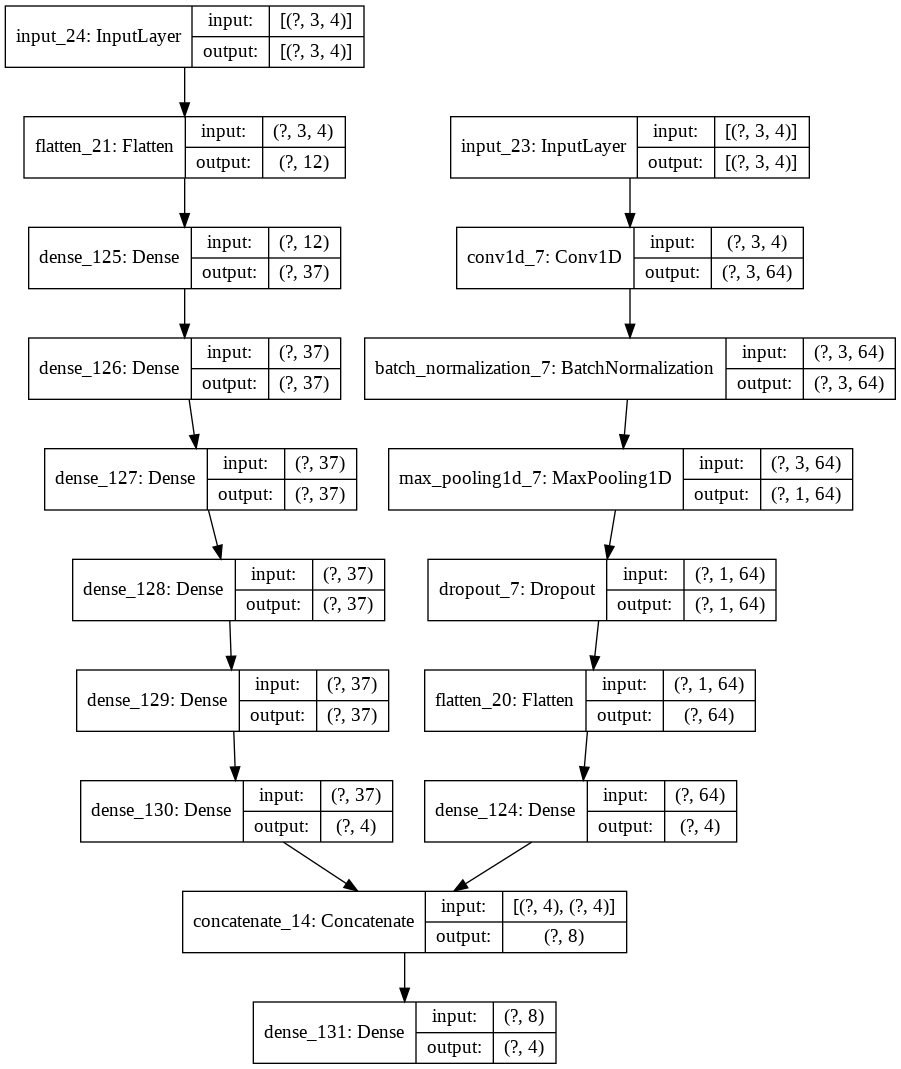

In [249]:
plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [251]:
model.compile(optimizer='adam', loss='mse')

In [252]:
es= EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)
model.fit([Sx,Sx], Sy, epochs=3000, verbose=1,callbacks=[es])

Epoch 1/3000
93/93 [==============================] - 0s 3ms/step - loss: 0.2126
Epoch 2/3000
93/93 [==============================] - 0s 3ms/step - loss: 0.0671
Epoch 3/3000
93/93 [==============================] - 0s 3ms/step - loss: 0.0401
Epoch 4/3000
93/93 [==============================] - 0s 3ms/step - loss: 0.0284
Epoch 5/3000
93/93 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 6/3000
93/93 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 7/3000
93/93 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 8/3000
93/93 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 9/3000
93/93 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 10/3000
93/93 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 11/3000
93/93 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 12/3000
93/93 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 13/3000
93/93 [====

In [253]:
test=mm_sc.transform(St_sc.transform(test_df.values))

In [254]:
stacked_raw=train[-n_steps:,:]
new_raws=np.array([0]*4)
for i in range(test.shape[0]):
    new_raw=model.predict([stacked_raw[i:i+10,:][np.newaxis,:,:],stacked_raw[i:i+10,:][np.newaxis,:,:]])
    new_raws=np.vstack([new_raws,new_raw])
    stacked_raw=np.vstack([stacked_raw,test[i,:][np.newaxis,:]])

In [255]:
Predict_result=St_sc.inverse_transform(mm_sc.inverse_transform(new_raws))[1:,0]
Test_values=test_df.values[:,0]

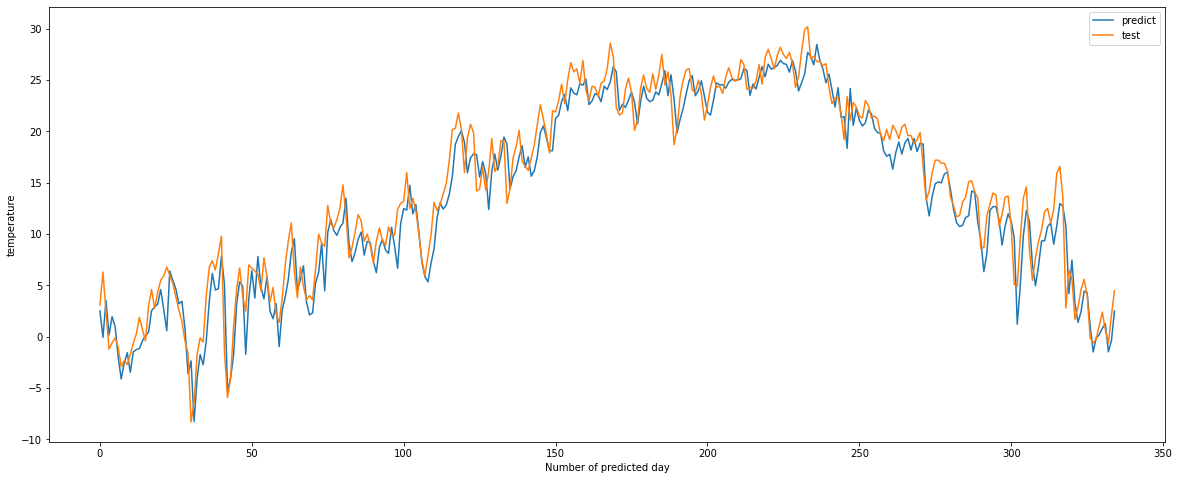

In [260]:
plt.plot(Predict_result,label='predict')
plt.plot(Test_values,label='test')
plt.ylabel('temperature')
plt.rcParams["figure.figsize"] = (20,8)
plt.xlabel('Number of predicted day')
plt.legend()
plt.show()

In [257]:
mean_squared_error(Predict_result,Test_values)

4.728016383121933

In [258]:
def accuracy(Predict,Test,offset):
  return (Predict[abs(Predict-Test) < offset].size /Test.size)*100
accuracy(Predict_result,Test_values,2.5)

76.4179104477612